In [1]:
import pandas as pd
import geopy.distance
import numpy as np

cityDf = pd.read_csv("city-basics_iowa.csv")
cityDf = cityDf.drop(['Unnamed: 0', 'Area (sqmi)', 'Area (sqkm)', 'WikiURL', 'Counties'], axis=1)

childCare = pd.read_csv('iowa-childcare.csv')
childCare = childCare.drop(['Unnamed: 0', 'Lat', 'Lon'], axis=1)

evictions = pd.read_csv('iowa-evictions.csv')
evictions = evictions.drop(['Unnamed: 0', 'Lat', 'Lon'], axis=1)

scalarDf = pd.merge(pd.merge(cityDf, childCare, on="City"), evictions, on="City")

def getDistance(row):
    hLat = row['lat home']
    hLon = row['lon home']
    wLat = row['lat work']
    wLon = row['lon work']
    d = geopy.distance.vincenty((hLat, hLon), (wLat, wLon)).km
    return d

jobsIn = pd.read_csv('iowa-work-flow.csv').drop(['Unnamed: 0'], axis=1)
jobsIn['Distance'] = jobsIn.apply(getDistance, axis=1)

def getPop(city):
    return float(cityDf[cityDf['City'] == city]['Population'])

jobsIn['Population'] = jobsIn['work city'].apply(getPop)

def calcMagnitude(row):
    return row['total jobs'] / row['City Jobs']

cities = list(jobsIn['work city'].unique())
totalJobs = dict()

for city in cities:
    totalJobs[city] = jobsIn[jobsIn['work city'] == city]['total jobs'].sum()
    
totalJobsDF = pd.DataFrame(list(totalJobs.items()), columns=["work city","City Jobs"])

jobsIn = pd.merge(totalJobsDF, jobsIn, on=["work city"])

jobsIn['normalized jobs'] = jobsIn.apply(calcMagnitude, axis=1)
jobsIn['normalized distance'] = jobsIn['Distance'] * jobsIn['normalized jobs']

jobsOut = pd.read_csv('iowa-job-out.csv').drop(["Unnamed: 0"], axis=1)
jobsOut['Distance'] = jobsOut.apply(getDistance, axis=1)
jobsOut['Population'] = jobsOut['home city'].apply(getPop)

cities = list(jobsOut['home city'].unique())
totalJobs = dict()

for city in cities:
    totalJobs[city] = jobsOut[jobsOut['home city'] == city]['total jobs'].sum()
    
totalJobsDF = pd.DataFrame(list(totalJobs.items()), columns=["home city","City Jobs"])

jobsOut = pd.merge(totalJobsDF, jobsOut, on=["home city"])

jobsOut['normalized jobs'] = jobsOut.apply(calcMagnitude, axis=1)
jobsOut['normalized distance'] = jobsOut["Distance"] * jobsOut["normalized jobs"]    

dist50 = dict()
dist90 = dict()
dist95 = dict()
dist99 = dict()
for city in cities:
    q = np.quantile(list(jobsIn[jobsIn['work city'] == city]['normalized distance']), [0.5, 0.9, 0.95, 0.99])
    dist50[city] = q[0]
    dist90[city] = q[1]
    dist95[city] = q[2]
    dist99[city] = q[3]
    
temp = pd.merge(pd.DataFrame(list(dist50.items()), columns=["City", "Q50 In"]), 
                pd.DataFrame(list(dist90.items()), columns=["City", "Q90 In"]), on="City")
temp = pd.merge(temp,
                pd.DataFrame(list(dist95.items()), columns=["City", "Q95 In"]), on="City")
temp = pd.merge(temp,
                pd.DataFrame(list(dist99.items()), columns=["City", "Q99 In"]), on="City")

scalarNew = pd.merge(scalarDf, temp, on="City")

dist50 = dict()
dist90 = dict()
dist95 = dict()
dist99 = dict()
for city in cities:
    q = np.quantile(list(jobsOut[jobsOut['home city'] == city]['normalized distance']), [0.5, 0.9, 0.95, 0.99])
    dist50[city] = q[0]
    dist90[city] = q[1]
    dist95[city] = q[2]
    dist99[city] = q[3]
    
temp = pd.merge(pd.DataFrame(list(dist50.items()), columns=["City", "Q50 Out"]), 
                pd.DataFrame(list(dist90.items()), columns=["City", "Q90 Out"]), on="City")
temp = pd.merge(temp,
                pd.DataFrame(list(dist95.items()), columns=["City", "Q95 Out"]), on="City")
temp = pd.merge(temp,
                pd.DataFrame(list(dist99.items()), columns=["City", "Q99 Out"]), on="City")

scalarNew = pd.merge(scalarNew, temp, on="City")

propLocalsWorking = jobsOut[jobsOut["home city"] == jobsOut["work city"]][['home city', 'normalized jobs']]
propWorkersLocal = jobsIn[jobsIn["home city"] == jobsIn["work city"]][['home city', 'normalized jobs']]
propLocalsWorking.columns = ['City', 'Prop Locals Working']
propWorkersLocal.columns = ['City', 'Prop Workers Local']
temp = pd.merge(propLocalsWorking, propWorkersLocal, on="City")
scalarNew = pd.merge(temp, scalarNew, on="City")
scalarNew = scalarNew.rename(columns={"Capacity" : "Child Care Capacity"})
scalarNew['Scaled Child Care'] = scalarNew['Child Care Capacity'] / scalarNew['Population']

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
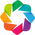

/anaconda3/envs/TEST/lib/python3.6/site-packages/holoviews/core/data/pandas.py:130: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  zip(columns, data)])


:Chord   [home id,work id]   (total jobs)
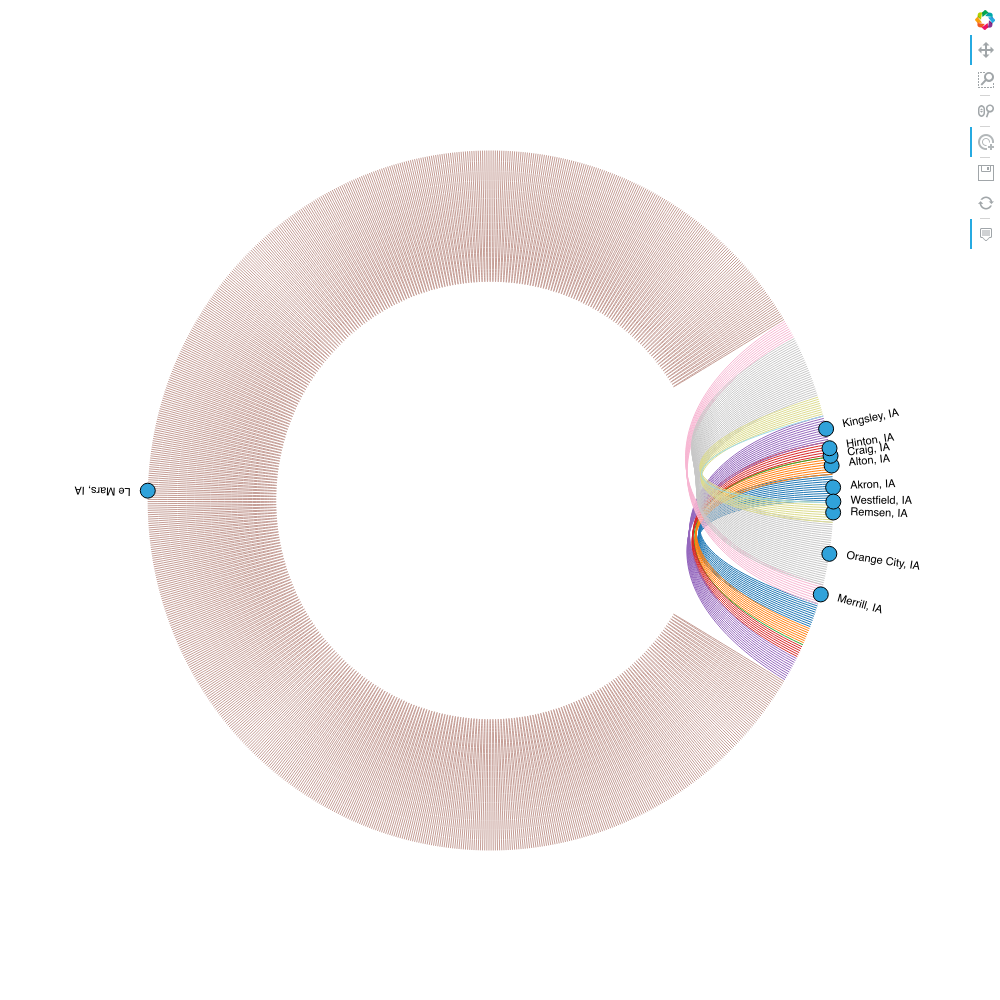

In [5]:
import holoviews as hv
from bokeh.sampledata.airport_routes import routes, airports

hv.extension('bokeh', 'matplotlib')

city = "Le Mars, IA"
threshold = 0.05
dataSet = jobsIn

inChords = dataSet[["work city", "home city", "total jobs", "normalized jobs"]]
inChords = inChords[inChords["home city"] == city]
inChords = inChords[inChords["normalized jobs"] > threshold]
values = list(range(0, len(inChords["work city"].unique())))
keys = inChords["work city"].unique()
cityToId = dict(zip(keys, values))
idToCity = dict(zip(values, keys))
inChords["work id"] = inChords["work city"].apply(lambda x: int(cityToId[x]))
inChords["home id"] = inChords["home city"].apply(lambda x: int(cityToId[x]))
inChords["total jobs"] = inChords["total jobs"].apply(lambda x: int(x))
inChords = inChords[["work id", "home id", "total jobs"]]
citiesDF = pd.DataFrame.from_dict(cityToId, orient="index").reset_index()
citiesDF.columns = ["Cities", "ID"]
citiesDF["ID"] = citiesDF["ID"].apply(lambda x: int(x))
citiesDF["Cities"] = citiesDF["Cities"].astype('|S')
nodes = hv.Dataset(citiesDF, "ID", "Cities")
chords = hv.Chord((inChords, nodes), ["home id", "work id"], ["total jobs"])

%opts Chord [edge_color_index='work id' label_index='Cities' color_index='home id' width=1000 height=1000]
%opts Chord (cmap='Category20' edge_cmap='Category20')
%output filename="le_mars-plot-0.05" fig="png"
chords